In [1]:
import numpy as np
import pandas as pd
from numpy.random import beta
from numpy.random import normal
from numpy.random import gamma
import matplotlib.pyplot as plt
import os
from scipy.stats import ks_2samp
from scipy.stats import wilcoxon

# Parameters recovery

## Difficulty/Discrimination and Ability

In [2]:
N = 500 # Respondents
M = 50 # Items

ability = beta(a = 1.0, b = 1.0, size = N)
difficulty = beta(a = 1.0, b = 1.0, size = M)
discrimination = normal(loc = 1.0, scale = 1, size = M)
parameters = np.array([difficulty, discrimination]).T

## Estimating Alpha and Beta parameters

In [4]:
def Alpha_ij(theta_i, delta_j, a_j):
    div = delta_j/theta_i
    alpha = div ** (a_j)
    return alpha

In [5]:
def Beta_ij(theta_i, delta_j, a_j):
    num = (1 - delta_j)
    denom = (1 - theta_i)
    div = num/denom
    beta = div ** (a_j)
    return beta

In [6]:
Alpha = np.zeros((N, M))
Beta = np.zeros((N, M))
for i, theta in enumerate(ability):
    for j, params in enumerate(parameters):
        Alpha[i, j] = Alpha_ij(theta, params[0], params[1])
        Beta[i, j] = Beta_ij(theta, params[0], params[1])

## Estimating the errors from Gamma distribution

In [7]:
# Gamma parameterisation
# shape, scale, = alpha, 1/beta

errors = gamma(shape = Alpha, scale = 1/Beta)

In [8]:
errors.shape

(500, 50)

In [9]:
responses = 1/(1 + errors)
responses = np.clip(responses, 1e-7, 1-1e-7)

In [11]:
name = 'irt_data_recovery_s' + str(M) + '_f0_sd0.csv'
header = str(list(range(N)))[1:-1]
np.savetxt('./beta_irt/' + name, responses.T, delimiter=',', header=header)

## Inference to find new Parameters and Abilities

In [12]:
os.chdir('./beta_irt/')
os.system('python betairt_test.py ' + name)
os.chdir('..')

In [15]:
parameters_ = pd.read_csv('./beta_irt/results/recovery/irt_parameters_vi_recovery_s' + str(len(difficulty)) + '_f0_sd0_am1@0_as1@0.csv')
ability_ = pd.read_csv('./beta_irt/results/recovery/irt_ability_vi_recovery_s' + str(len(difficulty)) + '_f0_sd0_am1@0_as1@0.csv')

WilcoxonResult(statistic=478.0, pvalue=0.12363399711559386)
WilcoxonResult(statistic=458.0, pvalue=0.08313770889364551)
WilcoxonResult(statistic=48881.0, pvalue=2.1182717558476713e-05)


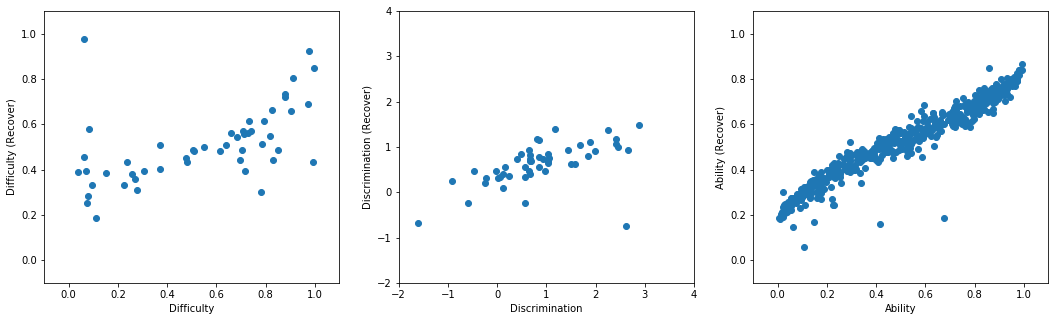

In [20]:
fig, axes = plt.subplots(nrows= 1, ncols= 3, figsize=(18,5))
labels = ['Difficulty', 'Discrimination']
for i in range(parameters.shape[1]):
    axes[i].scatter(parameters[:, i], parameters_.values[:, i])
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel(labels[i] + ' (Recover)')
    print(wilcoxon(parameters[:, i], parameters_.values[:, i]))
axes[-1].scatter(ability, ability_.iloc[:-1, -1].values)
axes[-1].set_xlabel('Ability')
axes[-1].set_ylabel('Ability (Recover)')

for i in [0,2]:
    axes[i].set_xlim([-.1,1.1])
    axes[i].set_ylim([-.1,1.1])
axes[1].set_xlim([-2,4])
axes[1].set_ylim([-2,4])
print(wilcoxon(ability, ability_.iloc[:-1, -1].values))